<a href="https://colab.research.google.com/github/nateraw/huggingface-hub-examples/blob/main/keras_integration_overview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
! pip install git+https://github.com/huggingface/huggingface_hub.git@main
! sudo apt -qq install git-lfs
! git config --global credential.helper store

## Make sure you're logged in to Hugging Face CLI

In [2]:
! huggingface-cli login


        _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
        _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
        _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
        _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
        _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

        
Username: nateraw
Password: 
Login successful
Your token has been saved to /root/.huggingface/token


# Simple Example

### Sequential API

In [ ]:
import tensorflow as tf
from huggingface_hub import push_to_hub_keras

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(2, activation="relu"))
model.compile(optimizer="adam", loss="mse")

# Your model must be built in order to push it!
model.build((None, 2))

push_to_hub_keras(model, 'keras-dummy-sequential-demo')

In [ ]:
from huggingface_hub import from_pretrained_keras

# Replace nateraw with your username that you logged in with!
m = from_pretrained_keras('nateraw/keras-dummy-sequential-demo')

In [ ]:
m.summary()

### Functional API

In [ ]:
inputs = tf.keras.layers.Input(shape=(2,))
x = tf.keras.layers.Dense(2, activation="relu")(inputs)
model = tf.keras.models.Model(inputs=inputs, outputs=x)
model.compile(optimizer="adam", loss="mse")

# No need to build with functional, as the Input layer has already defined the graph
push_to_hub_keras(model, 'keras-dummy-functional-demo')

Cloning https://huggingface.co/nateraw/keras-dummy-functional-demo into local empty directory.


INFO:tensorflow:Assets written to: keras-dummy-functional-demo/assets


To https://huggingface.co/nateraw/keras-dummy-functional-demo
   387ef32..c210f23  main -> main



'https://huggingface.co/nateraw/keras-dummy-functional-demo/commit/c210f23c36fb94eedad5348952d59ba491e4c624'

### Keras Mixin

In [ ]:
from huggingface_hub import KerasModelHubMixin


class DummyModel(tf.keras.Model, KerasModelHubMixin):
    def __init__(self, **kwargs):
        super().__init__()
        self.config = kwargs.pop("config", None)
        self.l1 = tf.keras.layers.Dense(2, activation="relu")
        dummy_batch_size = input_dim = 2
        self.dummy_inputs = tf.ones([dummy_batch_size, input_dim])

    def call(self, x):
        return self.l1(x)

model = DummyModel()

# Your model must be built!
# Here we use dummy inputs defined in the model itself, a recommended best practice taken from keras docs
model(model.dummy_inputs)

model.push_to_hub('keras-dummy-model-mixin-demo', git_email='naterawdata@gmail.com', git_user='nateraw')

Cloning https://huggingface.co/nateraw/keras-dummy-model-mixin-demo into local empty directory.


INFO:tensorflow:Assets written to: keras-dummy-model-mixin-demo/assets


To https://huggingface.co/nateraw/keras-dummy-model-mixin-demo
   f01edea..a4e2545  main -> main



Upload file saved_model.pb:  13%|#2        | 3.44k/26.6k [00:00<?, ?B/s]

'https://huggingface.co/nateraw/keras-dummy-model-mixin-demo/commit/a4e2545580d5f7ebff8e09c9f437675bc4738fa6'

# Complete Example

This is a more complete example of training a denoising autoencoder (taken from [keras-io/examples](https://github.com/keras-team/keras-io/blob/master/examples/vision/autoencoder.py))

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

In [ ]:
def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

## Prepare the data

11501568/11490434 [==============================] - 0s 0us/step


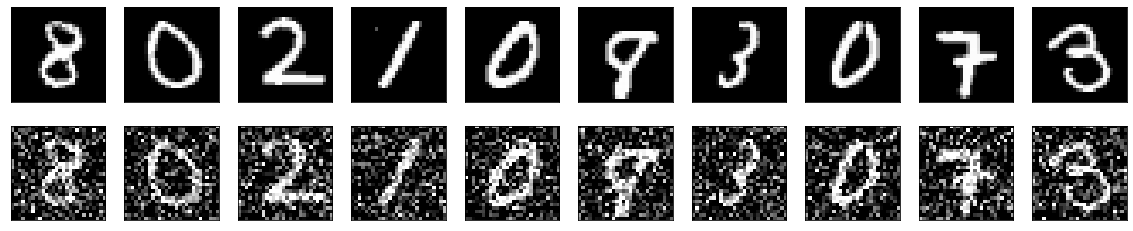

In [ ]:
# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
(train_data, _), (test_data, _) = mnist.load_data()

# Normalize and reshape the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Create a copy of the data with added noise
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

## Build the Autoencoder

We are going to use the Functional API to build our convolutional autoencoder.

In [ ]:
input = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 32)        9248      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        9248

## Train the Autoencoder on Noisy Data

We want our autoencoder to learn how to denoise the images.

In [ ]:
autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

Epoch 1/10
469/469 [==============================] - 19s 7ms/step - loss: 0.1837 - val_loss: 0.1043
Epoch 2/10
469/469 [==============================] - 3s 6ms/step - loss: 0.1009 - val_loss: 0.0971
Epoch 3/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0967 - val_loss: 0.0948
Epoch 4/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0945 - val_loss: 0.0928
Epoch 5/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0929 - val_loss: 0.0917
Epoch 6/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0917 - val_loss: 0.0907
Epoch 7/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0909 - val_loss: 0.0898
Epoch 8/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0901 - val_loss: 0.0894
Epoch 9/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0895 - val_loss: 0.0886
Epoch 10/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0890 - val_loss: 0.088

## Make Predictions

Let's now predict on the noisy data and display the results of our autoencoder.
Notice how the autoencoder does an amazing job at removing the noise from the
input images.

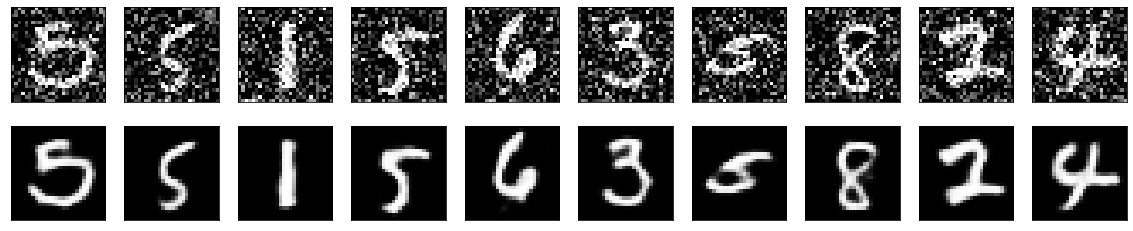

In [ ]:
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)

## Push Autoencoder to Hugging Face Hub

In [ ]:
from huggingface_hub import push_to_hub_keras

push_to_hub_keras(autoencoder, 'autoencoder-keras-mnist-demo')

Cloning https://huggingface.co/nateraw/autoencoder-keras-mnist-demo into local empty directory.


INFO:tensorflow:Assets written to: autoencoder-keras-mnist-demo/assets


Upload file saved_model.pb:   2%|1         | 3.44k/194k [00:00<?, ?B/s]

To https://huggingface.co/nateraw/autoencoder-keras-mnist-demo
   eaeb27c..581b84c  main -> main



'https://huggingface.co/nateraw/autoencoder-keras-mnist-demo/commit/581b84caceb8597e6e3e31773b8f03422402ccaf'

## Reload from hub and make predictions!

In [ ]:
from huggingface_hub import from_pretrained_keras

reloaded_model = from_pretrained_keras('nateraw/autoencoder-keras-mnist-demo')

config.json not found in HuggingFace Hub


Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/20.0k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/199k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/348k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.62k [00:00<?, ?B/s]

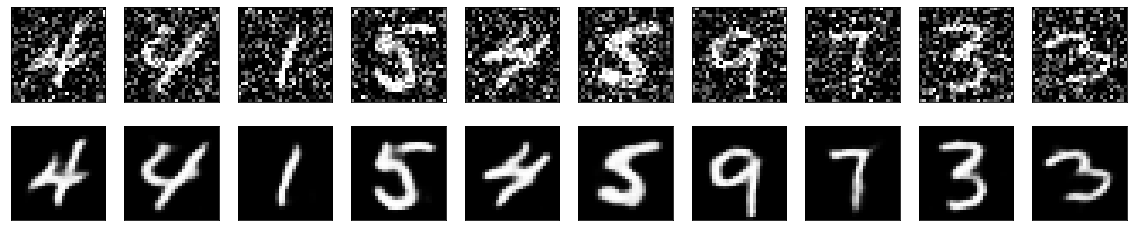

In [ ]:
predictions = reloaded_model.predict(noisy_test_data)
display(noisy_test_data, predictions)